In [2]:
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import itertools
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import math
from mpl_toolkits.basemap import Basemap
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import plotly.express as px

/Users/garimendra/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
with ZipFile('Coursework/Dataset/OneDrive_2_10-23-2022.zip', 'r') as zip:
    zip.printdir()
  
    print('Extracting all the files now...')
    zip.extractall('Coursework/Dataset/Zip2')
    print('Done!')

In [ ]:
parent_directory = os.fsencode('Coursework/Dataset/Zip2')
file_count = 0
total_tweet = 0
tweet_dict = {"id": [], 
              "tweet_created_at": [], 
              "user_id": [],
              "user_name": [],
              "country_code": [],
              "tweet_mentions": [],
              "text": [],
              "place_bounding_box": [],
              "coordinates": [],
             }

for folder in os.listdir(parent_directory):
    folder_name = os.fsdecode(folder)
    with ZipFile(parent_directory.decode("utf-8") + '/' + folder_name) as zip_archive:
        for item in zip_archive.filelist:
            print(item.filename)
            json_file_data = zip_archive.read(item.filename)
            json_file_data_string = json_file_data.decode("utf-8")
            json_file_data_list = json_file_data_string.split("\n")
                
            for tweet in json_file_data_list:
                if tweet:
                    total_tweet += 1
                    json_tweet = json.loads(tweet)  
                    if 'id_str' and 'created_at' and 'user' and 'place' and 'entities' and 'text' in json_tweet :
                        if None not in (json_tweet['id_str'], 
                                        json_tweet['created_at'], 
                                        json_tweet['user'], 
                                        json_tweet['place'],
                                        json_tweet['entities'],
                                        json_tweet['text']):
                            tweet_dict['id'].append(json_tweet['id_str'])
                            tweet_dict['tweet_created_at'].append(json_tweet['created_at'])
                            tweet_dict['user_id'].append(json_tweet['user']['id_str'])
                            tweet_dict['user_name'].append(json_tweet['user']['screen_name'])
                            tweet_dict['country_code'].append(json_tweet['place']['country_code'])
                            tweet_dict['tweet_mentions'].append(json_tweet['entities']['user_mentions'])
#                             tweet_dict['text'].append(json_tweet['text'])
#                             tweet_dict['place_bounding_box'].append(json_tweet['place']['bounding_box'])
#                             if 'coordinates' in json_tweet:
#                                 if json_tweet['coordinates'] != None:
#                                     tweet_dict['coordinates'].append(json_tweet['place']['bounding_box'])
#                             else:
#                                 tweet_dict['coordinates'].append(np.nan)
            # Capturing high level tweet statistics
            file_count += 1                

## Part 1

In [ ]:
# ........................
# ........................
# Fetching Data For Part 1
# ........................
# ........................

parent_directory = os.fsencode('Coursework/Dataset/Zip2')
file_count = 0
total_tweet = 0
tweet_dict1 = {"id": [], 
              "tweet_created_at": []
             }

for folder in os.listdir(parent_directory):
    folder_name = os.fsdecode(folder)
    with ZipFile(parent_directory.decode("utf-8") + '/' + folder_name) as zip_archive:
        for item in zip_archive.filelist:
            print(item.filename)
            json_file_data = zip_archive.read(item.filename)
            json_file_data_string = json_file_data.decode("utf-8")
            json_file_data_list = json_file_data_string.split("\n")
                
            for tweet in json_file_data_list:
                if tweet:
                    total_tweet += 1
                    json_tweet = json.loads(tweet)  
                    if 'id_str' and 'created_at' and 'text' in json_tweet :
                        if None not in (json_tweet['id_str'], 
                                        json_tweet['created_at'], 
                                        json_tweet['text']):
                            tweet_dict1['id'].append(json_tweet['id_str'])
                            tweet_dict1['tweet_created_at'].append(json_tweet['created_at'])
            # Capturing high level tweet statistics
            file_count += 1                

In [ ]:
print("file_count = {}".format(file_count))

### 1.1. Count the total number of tweets, describing how you deal with duplicates or other anomalies in the data set. [5 marks]

In [ ]:
csv_dump_file = 'tweets_df1.csv'
tweets_df1 = pd.DataFrame(tweet_dict1)
tweets_df1.to_csv(csv_dump_file, sep=',', encoding='utf-8')

In [ ]:
tweets_df1.head()

In [ ]:
tweets_df1 = pd.read_csv('tweets_df1.csv', index_col=[0])
tweets_df1.dropna(subset=['id'])
tweets_df1['tweet_created_at'] =  pd.to_datetime(tweets_df1['tweet_created_at'], format='%a %b %d %H:%M:%S %z %Y')
tweets_df1 = tweets_df1[ (tweets_df1['tweet_created_at'].dt.date >= 
                          datetime.strptime('Jun 1 2022', '%b %d %Y').date()) ]
tweets_df1.sort_values(['tweet_created_at', 'id'], inplace=True)
tweets_df1.drop_duplicates(subset='id',keep='first', inplace=True)

In [ ]:
tweets_df1.head()

In [ ]:
# Tweet Count
print("total tweets = {}".format(total_tweet)) # total tweets in all files without any processing
print("Total tweets without anomalies and duplicates = {}".format(tweets_df1.shape[0]))

In [ ]:
# according to twitter documentation, there are a few fundamental data elements in root level like id and created_at
# Tweets which don't have these fields can be considered anomalies as a tweet without a uniique identifier(id/ id_str)
# and created_at field can not be used for plotting on time series. 
# For duplicate tweets (tweets with same id/ id_str), we are cosnidering the tweet which was tweeted first and 
# discarding later tweets as duplicates are not fit for analysis.

### 1.2. Plot a time-series of the number of tweets by day using the whole dataset and comment on what you see. [5 marks]

In [ ]:
tweets_day_df = tweets_df1.copy()
tweets_day_df['tweet_created_at'] = pd.to_datetime(tweets_day_df['tweet_created_at']).dt.date
tweets_day_df = tweets_day_df.groupby(['tweet_created_at']).count()

In [ ]:
fig, ax = plt.subplots(figsize = (10, 12))    
bars = ax.barh(tweets_day_df.index, tweets_day_df['id'], color = '#00acee')
ax.axis([450000,
         550000,
         pd.to_datetime('01 June 2022'),
         pd.to_datetime('30 June 2022')])
ax.bar_label(bars)
plt.title('Tweets per day')
plt.yticks(tweets_day_df.index)
plt.xlabel('Number of Tweets')

plt.ylabel('Date')  
plt.show()

### 1.3. Use box and whisker diagrams to compare the average number of tweets on weekdays to the numbers for weekend days. Are there statistically significant differences between the number of tweets on weekdays and weekends? [5 marks]

In [ ]:
tweets_weekday_weekend = { 'weekday': 0, 'weekend': 0}
weekday_count = 0
weekend_count = 0

for idx, row in tweets_day_df.iterrows():
    if idx.weekday() < 5:
        tweets_weekday_weekend['weekday'] += int(row['id'])
        weekday_count += 1
    else:
        tweets_weekday_weekend['weekend'] += int(row['id'])
        weekend_count += 1

print("Weekends Average:", tweets_weekday_weekend['weekend']/ weekend_count)
print("Weekdays Average:", tweets_weekday_weekend['weekday']/ weekday_count)

In [ ]:
labels = tweets_weekday_weekend.keys()
values = [[weekend_count,tweets_weekday_weekend['weekend']/ weekend_count], 
          [weekday_count,tweets_weekday_weekend['weekday']/ weekday_count]]
plt.figure(figsize=(8, 5), dpi=80)
c = "black"
plt.boxplot(values, vert = True, 
            patch_artist=True,
            boxprops=dict(facecolor='#00acee', color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

### 1.4. Plot a time-series of the number of tweets by hour, averaged over all weekdays and comment on what you see. [5 marks]

In [ ]:
tweets_weekday_hourly = {}

for idx, row in tweets_df1.iterrows():
    if row['tweet_created_at'].hour in tweets_weekday_hourly:
        tweets_weekday_hourly[ row['tweet_created_at'].hour ] += 1
    else:
        tweets_weekday_hourly[ row['tweet_created_at'].hour ] = 1 

In [ ]:
for hour in tweets_weekday_hourly:
    tweets_weekday_hourly[hour] /= 30

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(tweets_weekday_hourly.keys(), tweets_weekday_hourly.values(), color = '#00acee')
plt.xticks(list(tweets_weekday_hourly.keys()))
for x in list(tweets_weekday_hourly.keys()):
    plt.axvline(x=x, color='black', alpha = 0.2)
plt.xlabel("Hour of the day")
plt.ylabel("Average tweets")
plt.xlim(0, 23)
plt.show()

In [ ]:
del tweets_df1
del tweets_day_df

## Part 2

In [ ]:
# ........................
# ........................
# Fetching Data For Part 2
# ........................
# ........................

parent_directory = os.fsencode('Coursework/Dataset/Zip2')
tweet_dict2 = {"id": [], 
              "tweet_created_at": [], 
              "user_id": [],
              "user_name": [],
              "country_code": [],
              "tweet_mentions": []
             }

for folder in os.listdir(parent_directory):
    folder_name = os.fsdecode(folder)
    with ZipFile(parent_directory.decode("utf-8") + '/' + folder_name) as zip_archive:
        for item in zip_archive.filelist:
            print(item.filename)
            json_file_data = zip_archive.read(item.filename)
            json_file_data_string = json_file_data.decode("utf-8")
            json_file_data_list = json_file_data_string.split("\n")
                
            for tweet in json_file_data_list:
                if tweet:
                    json_tweet = json.loads(tweet)  
                    if 'id_str' and 'created_at' and 'user' and 'place' and 'entities' and 'text' in json_tweet :
                        if None not in (json_tweet['id_str'], 
                                        json_tweet['created_at'], 
                                        json_tweet['user'], 
                                        json_tweet['place'],
                                        json_tweet['entities'],
                                        json_tweet['text']):
                            tweet_dict2['id'].append(json_tweet['id_str'])
                            tweet_dict2['tweet_created_at'].append(json_tweet['created_at'])
                            tweet_dict2['user_id'].append(json_tweet['user']['id_str'])
                            tweet_dict2['user_name'].append(json_tweet['user']['screen_name'])
                            tweet_dict2['country_code'].append(json_tweet['place']['country_code'])
                            tweet_dict2['tweet_mentions'].append(json_tweet['entities']['user_mentions'])

In [ ]:
csv_dump_file2 = 'tweets_df2.csv'
tweets_df2 = pd.DataFrame(tweet_dict2)
tweets_df2.to_csv(csv_dump_file2, sep=',', encoding='utf-8')

In [ ]:
tweets_df2 = pd.read_csv('tweets_df2.csv', index_col=[0])
tweets_df2.dropna(subset=['id'])
tweets_df2['tweet_created_at'] =  pd.to_datetime(tweets_df2['tweet_created_at'], format='%a %b %d %H:%M:%S %z %Y')
tweets_df2 = tweets_df2[ (tweets_df2['tweet_created_at'].dt.date >= datetime.strptime('Jun 1 2022', '%b %d %Y').date()) ]
tweets_df2.sort_values(['tweet_created_at', 'id'], inplace=True)
tweets_df2.drop_duplicates(subset='id',keep='first', inplace=True)

### 2.1. Make a histogram with the number of users on the y-axis and number of tweets they make on the x-axis. Discuss the distribution that you see. All the users in the data set should be included! [5 marks]

In [ ]:
tweets_user_df = tweets_df2.copy()

In [ ]:
tweets_user_df = pd.DataFrame(tweets_user_df['user_id'].value_counts().reset_index())
tweets_user_df.columns = ['user_id', 'tweet_count']

plt.hist(tweets_user_df['tweet_count'], log = True, color = '#00acee')
plt.show()

In [ ]:
plt.hist(tweets_user_df['tweet_count'], color = '#00acee')
plt.show()

In [ ]:
plt.hist(tweets_user_df['tweet_count'], log = True, color = '#00acee')
plt.xlabel("Number of tweets")
plt.ylabel("Log of number of users")
plt.show()

### 2.2. Find the top-5 users by total number of tweets. Do you think any are automated accounts (aka. bots)? Justify your answer. [5 marks]

In [ ]:
top_5_users = tweets_user_df[0:5]

user_name = []
for user_id in top_5_users['user_id']:
    user_name.append(tweets_df2.loc[tweets_df2['user_id'] == user_id].iloc[0]['user_name'])
    
top_5_users['user_name'] = user_name

In [ ]:
top_5_users

In [ ]:
del tweets_user_df

### 2.3 Find the 5 users who receive the most mentions and comment on this. [5 marks]

In [ ]:
user_mentions = np.array(tweets_df2['tweet_mentions'])
user_mentions = user_mentions[user_mentions != '[]']

In [ ]:
mention_freq = {}

for mentions in user_mentions:
    json_string = ast.literal_eval(mentions)
    for mention in json_string:
        if mention['name'] not in mention_freq:
            mention_freq[mention['name']] = 1
        else:
            mention_freq[mention['name']] += 1

In [ ]:
mention_freq = dict(sorted(mention_freq.items(), key=lambda item: item[1], reverse=True))
mention_freq = dict(itertools.islice(mention_freq.items(), 5))

In [ ]:
mention_freq

### 2.4. Choose 4 countries and compute how often they mention each other. This means you should compute 16 numbers e.g. UK mentions UK, UK mentions France, France mentions UK etc. Comment on any patterns you observe. [5 marks]

In [ ]:
tweets_country_mentions_df = tweets_df2.copy()
empty_mention = '[]'
df = df[df.tweet_mentions != empty_mention]

In [ ]:
tweets_country_mentions_df.head()

In [ ]:
ref_dict = {}
dict1 = {}

for idx, row in df.iterrows():
    if row['user_id'] not in ref_dict:
        ref_dict[ row['user_id'] ] = row['country_code']

empty_mention = '[]'
df = df[df.tweet_mentions != empty_mention]
        
for idx, row in df.iterrows():
    if row['country_code'] not in dict1:
        dict1[ row['country_code'] ] = []
        
    mentions = ast.literal_eval(row['tweet_mentions'])
    for mention in mentions:
        dict1[ row['country_code'] ].append(mention['id_str'])

In [ ]:
list_of_mentioning_countries = list(country_userid_dict.keys())

In [ ]:
user_country_dict = {}


In [ ]:
for k, v in dict1.items():
    for i in range(len(v)):
        if int(v[i]) in ref_dict:
            dict1[k][i] = ref_dict[int(v[i])]

In [ ]:
countries = {
    'DE': 'Germany',
    'BE': 'Belgium',
    'ES': 'Spain',
    'TR': 'Turkey'
}

mentions = {}

for i in countries.keys():
    if i not in mentions:
        mentions[i] = {}
        
    for j in countries.keys():
        mentions[i][j] = dict1[i].count(j)
        
print(mentions)

In [ ]:
country_mentions

In [ ]:
del tweets_country_mentions_df

## Part 3

### 3.1. Draw a map of Europe that displays the use of Twitter across the continent. Use only the GPS-tagged tweets, these are tweets which have a “coordinates” field in the metadata. The exact form of the map is up to you: marks will be given for accuracy, clarity and presentation. [10 marks]

In [3]:
# ........................
# ........................
# Fetching Data For Part 3.1
# ........................
# ........................

parent_directory = os.fsencode('Coursework/Dataset/Zip2')
tweet_dict3_1 = {"id": [],
               "tweet_created_at": [],
               "country_code": [],
               "longitude": [],
               "latitude": []
              }

for folder in os.listdir(parent_directory):
    folder_name = os.fsdecode(folder)
    with ZipFile(parent_directory.decode("utf-8") + '/' + folder_name) as zip_archive:
        for item in zip_archive.filelist:
            print(item.filename)
            json_file_data = zip_archive.read(item.filename)
            json_file_data_string = json_file_data.decode("utf-8")
            json_file_data_list = json_file_data_string.split("\n")
                
            for tweet in json_file_data_list:
                if tweet:
                    json_tweet = json.loads(tweet)  
                    if 'id_str' and 'created_at' and 'place' and 'text' and 'coordinates' in json_tweet :
                        if None not in (json_tweet['id_str'], 
                                        json_tweet['created_at'], 
                                        json_tweet['place'],
                                        json_tweet['text'],
                                        json_tweet['coordinates']):
                                tweet_dict3_1['id'].append(json_tweet['id_str'])
                                tweet_dict3_1['tweet_created_at'].append(json_tweet['created_at'])
                                tweet_dict3_1['country_code'].append(json_tweet['place']['country_code'])
                                tweet_dict3_1['longitude'].append(json_tweet['coordinates']['coordinates'][0])
                                tweet_dict3_1['latitude'].append(json_tweet['coordinates']['coordinates'][1])

geoEurope/geoEurope_2022061915.json
geoEurope/geoEurope_2022061901.json
geoEurope/geoEurope_2022060410.json
geoEurope/geoEurope_2022062207.json
geoEurope/geoEurope_2022062213.json
geoEurope/geoEurope_2022060404.json
geoEurope/geoEurope_2022060809.json
geoEurope/geoEurope_2022060821.json
geoEurope/geoEurope_2022062005.json
geoEurope/geoEurope_2022060612.json
geoEurope/geoEurope_2022060606.json
geoEurope/geoEurope_2022061518.json
geoEurope/geoEurope_2022062011.json
geoEurope/geoEurope_2022062818.json
geoEurope/geoEurope_2022062617.json
geoEurope/geoEurope_2022062603.json
geoEurope/geoEurope_2022061322.json
geoEurope/geoEurope_2022062415.json
geoEurope/geoEurope_2022060202.json
geoEurope/geoEurope_2022061108.json
geoEurope/geoEurope_2022060216.json
geoEurope/geoEurope_2022062401.json
geoEurope/geoEurope_2022061120.json
geoEurope/geoEurope_2022061121.json
geoEurope/geoEurope_2022062400.json
geoEurope/geoEurope_2022060217.json
geoEurope/geoEurope_2022061109.json
geoEurope/geoEurope_20220602

geoEurope/geoEurope_2022062918.json
geoEurope/geoEurope_2022060100.json
geoEurope/geoEurope_2022062717.json
geoEurope/geoEurope_2022062703.json
geoEurope/geoEurope_2022060114.json
geoEurope/geoEurope_2022061222.json
geoEurope/geoEurope_2022060909.json
geoEurope/geoEurope_2022060921.json
geoEurope/geoEurope_2022062105.json
geoEurope/geoEurope_2022060712.json
geoEurope/geoEurope_2022061418.json
geoEurope/geoEurope_2022060706.json
geoEurope/geoEurope_2022062111.json
geoEurope/geoEurope_2022061815.json
geoEurope/geoEurope_2022061801.json
geoEurope/geoEurope_2022060510.json
geoEurope/geoEurope_2022062307.json
geoEurope/geoEurope_2022063019.json
geoEurope/geoEurope_2022062313.json
geoEurope/geoEurope_2022060504.json
geoEurope/geoEurope_2022060505.json
geoEurope/geoEurope_2022062312.json
geoEurope/geoEurope_2022063018.json
geoEurope/geoEurope_2022062306.json
geoEurope/geoEurope_2022060511.json
geoEurope/geoEurope_2022061800.json
geoEurope/geoEurope_2022061814.json
geoEurope/geoEurope_20220621

geoEurope/geoEurope_2022060901.json
geoEurope/geoEurope_2022060915.json
geoEurope/geoEurope_2022060108.json
geoEurope/geoEurope_2022061216.json
geoEurope/geoEurope_2022061202.json
geoEurope/geoEurope_2022062723.json
geoEurope/geoEurope_2022060120.json
geoEurope/geoEurope_2022062904.json
geoEurope/geoEurope_2022062910.json
geoEurope/geoEurope_2022061014.json
geoEurope/geoEurope_2022061000.json
geoEurope/geoEurope_2022062509.json
geoEurope/geoEurope_2022062521.json
geoEurope/geoEurope_2022060322.json
geoEurope/geoEurope_2022061004.json
geoEurope/geoEurope_2022061010.json
geoEurope/geoEurope_2022062519.json
geoEurope/geoEurope_2022062914.json
geoEurope/geoEurope_2022062900.json
geoEurope/geoEurope_2022061206.json
geoEurope/geoEurope_2022060118.json
geoEurope/geoEurope_2022061212.json
geoEurope/geoEurope_2022060911.json
geoEurope/geoEurope_2022060905.json
geoEurope/geoEurope_2022061414.json
geoEurope/geoEurope_2022061400.json
geoEurope/geoEurope_2022062109.json
geoEurope/geoEurope_20220621

geoEurope/geoEurope_2022060420.json
geoEurope/geoEurope_2022060811.json
geoEurope/geoEurope_2022060805.json
geoEurope/geoEurope_2022061514.json
geoEurope/geoEurope_2022061500.json
geoEurope/geoEurope_2022062009.json
geoEurope/geoEurope_2022062021.json
geoEurope/geoEurope_2022060622.json
geoEurope/geoEurope_2022062814.json
geoEurope/geoEurope_2022062800.json
geoEurope/geoEurope_2022061306.json
geoEurope/geoEurope_2022061312.json
geoEurope/geoEurope_2022061104.json
geoEurope/geoEurope_2022061110.json
geoEurope/geoEurope_2022062419.json
geoEurope/geoEurope_2022062418.json
geoEurope/geoEurope_2022061111.json
geoEurope/geoEurope_2022061105.json
geoEurope/geoEurope_2022061313.json
geoEurope/geoEurope_2022061307.json
geoEurope/geoEurope_2022062801.json
geoEurope/geoEurope_2022062815.json
geoEurope/geoEurope_2022060623.json
geoEurope/geoEurope_2022062020.json
geoEurope/geoEurope_2022062008.json
geoEurope/geoEurope_2022061501.json
geoEurope/geoEurope_2022061515.json
geoEurope/geoEurope_20220608

In [4]:
csv_dump_file3_1 = 'tweets_df3_1.csv'
tweets_df3_1 = pd.DataFrame(tweet_dict3_1)
tweets_df3_1.to_csv(csv_dump_file3_1, sep=',', encoding='utf-8')

In [6]:
tweets_df3_1.shape

(695426, 5)

In [ ]:
# tweets_df3_1 = pd.read_csv('tweets_df3_1.csv', index_col=[0])
tweets_df3_1.dropna(subset=['id'])
tweets_df3_1['tweet_created_at'] =  pd.to_datetime(tweets_df3_1['tweet_created_at'], format='%a %b %d %H:%M:%S %z %Y')
tweets_df3_1 = tweets_df3_1[ (tweets_df3_1['tweet_created_at'].dt.date >= datetime.strptime('Jun 1 2022', '%b %d %Y').date()) ]
tweets_df3_1.sort_values(['tweet_created_at', 'id'], inplace=True)
tweets_df3_1.drop_duplicates(subset='id',keep='first', inplace=True)

In [ ]:
BBox = (tweets_df3_1.longitude.min(),   tweets_df3_1.longitude.max(),      
         tweets_df3_1.latitude.min(), tweets_df3_1.latitude.max())

In [ ]:
BBox

In [ ]:
g_map = gpd.read_file('Coursework/Dataset/world-administrative-boundaries/world-administrative-boundaries.shp')

In [ ]:
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

### 3.2. Explain any patterns you observe. [5 marks]

### 3.3. The rest of the tweets should have a “place” tag. For these tweets, plot the CDF of the bounding box diagonals and comment. [5 marks]

In [ ]:
# ........................
# ........................
# Fetching Data For Part 3.3
# ........................
# ........................

parent_directory = os.fsencode('Coursework/Dataset/Zip2')
tweet_dict3_3 = {"id": [],
               "tweet_created_at": [],
               "place_bounding_box": []
              }

for folder in os.listdir(parent_directory):
    folder_name = os.fsdecode(folder)
    with ZipFile(parent_directory.decode("utf-8") + '/' + folder_name) as zip_archive:
        for item in zip_archive.filelist:
            print(item.filename)
            json_file_data = zip_archive.read(item.filename)
            json_file_data_string = json_file_data.decode("utf-8")
            json_file_data_list = json_file_data_string.split("\n")
                
            for tweet in json_file_data_list:
                if tweet:
                    json_tweet = json.loads(tweet)  
                    if 'id_str' and 'created_at' and 'text' and 'place' in json_tweet :
                        if None not in (json_tweet['id_str'], 
                                        json_tweet['created_at'], 
                                        json_tweet['text'],
                                        json_tweet['place']):
                                tweet_dict3_3['id'].append(json_tweet['id_str'])
                                tweet_dict3_3['tweet_created_at'].append(json_tweet['created_at'])
                                tweet_dict3_3['place_bounding_box'].append(json_tweet['place']['bounding_box'])

In [ ]:
csv_dump_file3_3 = 'tweets_df3_3.csv'
tweets_df3_3 = pd.DataFrame(tweet_dict3_3)
tweets_df3_3.to_csv(csv_dump_file3_3, sep=',', encoding='utf-8')

In [7]:
tweets_df3_3 = pd.read_csv('tweets_df3_3.csv', index_col=[0])
tweets_df3_3.dropna(subset=['id'])
tweets_df3_3['tweet_created_at'] =  pd.to_datetime(tweets_df3_3['tweet_created_at'], format='%a %b %d %H:%M:%S %z %Y')
tweets_df3_3 = tweets_df3_3[ (tweets_df3_3['tweet_created_at'].dt.date >= datetime.strptime('Jun 1 2022', '%b %d %Y').date()) ]
tweets_df3_3.sort_values(['tweet_created_at', 'id'], inplace=True)
tweets_df3_3.drop_duplicates(subset='id',keep='first', inplace=True)

In [8]:
tweets_df3_3.head()

,id,tweet_created_at,place_bounding_box
5354563,1531787611706208260,2022-06-01 00:00:00+00:00,"{'type': 'Polygon', 'coordinates': [[[-1.57364..."
5354564,1531787612117159948,2022-06-01 00:00:00+00:00,"{'type': 'Polygon', 'coordinates': [[[13.08830..."
5354565,1531787615523020804,2022-06-01 00:00:01+00:00,"{'type': 'Polygon', 'coordinates': [[[13.08830..."
5354566,1531787616990990337,2022-06-01 00:00:01+00:00,"{'type': 'Polygon', 'coordinates': [[[8.916666..."
5354567,1531787617813110784,2022-06-01 00:00:01+00:00,"{'type': 'Polygon', 'coordinates': [[[29.33979..."


In [9]:
diag_bbox = []
for index, tweet in tweets_df3_3.iterrows():
    json_string = ast.literal_eval(tweet['place_bounding_box'])
    top_left = json_string['coordinates'][0][1]
    bottom_right = json_string['coordinates'][0][3]
    eDist = math.dist(top_left, bottom_right)
    diag_bbox.append(eDist)

In [10]:
diag_bbox

[0.28811740189200896,
 0.7524167738434581,
 0.7524167738434581,
 0.10764012035017625,
 0.17071177878810753,
 0.3011318221726166,
 0.7524167738434581,
 0.07650828491738734,
 0.07650828491738734,
 1.7626859306447653,
 0.4430078012225057,
 0.4974880941630646,
 0.7524167738434581,
 0.12384036988397232,
 0.05785618509718692,
 0.0982787980797494,
 0.24565890714566044,
 0.2760796529934775,
 0.04305741192872715,
 0.07228848274794594,
 0.26293904467195417,
 0.138195595476119,
 0.7883472599013744,
 0.260621367199623,
 0.1187595220266571,
 0.12035450500085274,
 0.09259496929099358,
 3.775141917610118,
 0.06460995208944156,
 0.0891758171815651,
 0.030616494525012097,
 0.8648640888012387,
 0.11937564200874545,
 0.05926441121786394,
 0.22819488652027206,
 0.2699668545451477,
 0.16355065819494444,
 0.2263762593316727,
 2.9511258843880257,
 0.14497728211688862,
 0.149619351803164,
 0.9559334316473094,
 0.61916321464457,
 0.173789487084229,
 0.15373191973042197,
 0.3533761110842109,
 0.0507431589083704

Text(0, 0.5, 'p(CDF)')

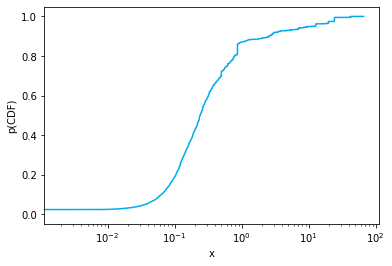

In [13]:
diagonal_data = diag_bbox
p = 1. * np.arange(len(diagonal_data)) / (len(diagonal_data) - 1)
plt.plot(sorted(diagonal_data),p, color = '#00acee')
plt.xscale('log')
plt.xlabel('x')
plt.ylabel('p(CDF)')

### 3.4. Find one additional spatial dataset, produce a map comparing Twitter activity with the other dataset and discuss. Your secondary dataset doesn’t have to cover the entire bounding box e.g. it could be for a single city or nation. [10 marks]

## Part 4

In [ ]:
# ........................
# ........................
# Fetching Data For Part 4
# ........................
# ........................

parent_directory = os.fsencode('Coursework/Dataset/Zip2')
tweet_dict4 = {"id": [], 
               "tweet_created_at": [], 
               "country_code": [],
               "text": []
              }

for folder in os.listdir(parent_directory):
    folder_name = os.fsdecode(folder)
    with ZipFile(parent_directory.decode("utf-8") + '/' + folder_name) as zip_archive:
        for item in zip_archive.filelist:
            print(item.filename)
            json_file_data = zip_archive.read(item.filename)
            json_file_data_string = json_file_data.decode("utf-8")
            json_file_data_list = json_file_data_string.split("\n")
                
            for tweet in json_file_data_list:
                if tweet:
                    json_tweet = json.loads(tweet)  
                    if 'id_str' and 'created_at' and 'place' and 'text' in json_tweet :
                        if None not in (json_tweet['id_str'], 
                                        json_tweet['created_at'], 
                                        json_tweet['place'],
                                        json_tweet['text']):
                            tweet_dict4['id'].append(json_tweet['id_str'])
                            tweet_dict4['tweet_created_at'].append(json_tweet['created_at'])
                            tweet_dict4['country_code'].append(json_tweet['place']['country_code'])
                            tweet_dict4['text'].append(json_tweet['text'])

In [ ]:
csv_dump_file4 = 'tweets_df4.csv'
tweets_df4 = pd.DataFrame(tweet_dict4)
tweets_df4.to_csv(csv_dump_file4, sep=',', encoding='utf-8')

In [ ]:
tweets_df4.head()

In [24]:
tweets_df4 = pd.read_csv('tweets_df4.csv', index_col=[0])
tweets_df4.dropna(subset=['id'])
tweets_df4['tweet_created_at'] =  pd.to_datetime(tweets_df4['tweet_created_at'], format='%a %b %d %H:%M:%S %z %Y')
tweets_df4 = tweets_df4[ (tweets_df4['tweet_created_at'].dt.date >= datetime.strptime('Jun 1 2022', '%b %d %Y').date()) ]
tweets_df4.sort_values(['tweet_created_at', 'id'], inplace=True)
tweets_df4.drop_duplicates(subset='id',keep='first', inplace=True)

/Users/garimendra/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### 4.1. Identify 3 days with unusually high activity in 3 different countries of your choosing. For example you could choose one day in the UK, one in France and one in Turkey. Describe and justify how you identify ‘unusual’ days. [5 marks]

In [25]:
tweets_df4.head()

,id,tweet_created_at,country_code,text
5354563,1.531788e+18,2022-06-01 00:00:00+00:00,GB,"Wind 3.0 mph NNW. Barometer 1015.1 hPa, Rising..."
5354564,1.531788e+18,2022-06-01 00:00:00+00:00,DE,"Social Media Manager (w/m/d), #Berlin, Fokus B..."
5354565,1.531788e+18,2022-06-01 00:00:01+00:00,DE,"Product Owner (w/m/d) Fokus eHealth, #Berlin (..."
5354566,1.531788e+18,2022-06-01 00:00:01+00:00,IT,"02:00\nTemp. 14,5°C App. 15,4°C\nUmid. 96% \nP..."
5354567,1.531788e+18,2022-06-01 00:00:01+00:00,TR,"Anlamadım bana mı küsüyor,gözlerini görmeyince..."


In [27]:
tweets_GB = tweets_df4[ tweets_df4['country_code'] == 'GB' ]
tweets_GB['tweet_created_at'] = pd.to_datetime(tweets_GB['tweet_created_at']).dt.date

tweets_FR = tweets_df4[ tweets_df4['country_code'] == 'FR' ]
tweets_FR['tweet_created_at'] = pd.to_datetime(tweets_FR['tweet_created_at']).dt.date

tweets_TR = tweets_df4[ tweets_df4['country_code'] == 'TR' ]
tweets_TR['tweet_created_at'] = pd.to_datetime(tweets_TR['tweet_created_at']).dt.date

/var/folders/xm/p2m92gfx7fxg0vpglltc5f6w0000gn/T/ipykernel_2539/2683079697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_GB['tweet_created_at'] = pd.to_datetime(tweets_GB['tweet_created_at']).dt.date
/var/folders/xm/p2m92gfx7fxg0vpglltc5f6w0000gn/T/ipykernel_2539/2683079697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_FR['tweet_created_at'] = pd.to_datetime(tweets_FR['tweet_created_at']).dt.date
/var/folders/xm/p2m92gfx7fxg0vpglltc5f6w0000gn/T/ipykernel_2539/2683079697.py:8: Setti

In [28]:
tweets_GB = pd.DataFrame(tweets_GB['tweet_created_at'].value_counts().reset_index())
tweets_GB.columns = ['date', 'tweet_count']

tweets_FR = pd.DataFrame(tweets_FR['tweet_created_at'].value_counts().reset_index())
tweets_FR.columns = ['date', 'tweet_count']

tweets_TR = pd.DataFrame(tweets_TR['tweet_created_at'].value_counts().reset_index())
tweets_TR.columns = ['date', 'tweet_count']

tweets_countries_dict = { 'United Kingdom': tweets_GB, 'France': tweets_FR, 'Turkey': tweets_TR}
tweets_countries_df = pd.concat(tweets_countries_dict.values(), axis=1, keys=tweets_countries_dict.keys())

In [29]:
tweets_countries_df.head()

United Kingdom                  France                  Turkey            
            date tweet_count        date tweet_count        date tweet_count
0     2022-06-24      133521  2022-06-19       41410  2022-06-28       94476
1     2022-06-01      126247  2022-06-17       38474  2022-06-01       92900
2     2022-06-14      125693  2022-06-16       38214  2022-06-12       92233
3     2022-06-25      124028  2022-06-12       37888  2022-06-29       91608
4     2022-06-17      122720  2022-06-15       37630  2022-06-27       89868

In [30]:
tweets_GB_sorted = tweets_GB.sort_values(['date'], inplace = False)
tweets_FR_sorted = tweets_FR.sort_values(['date'], inplace = False)
tweets_TR_sorted = tweets_TR.sort_values(['date'], inplace = False)

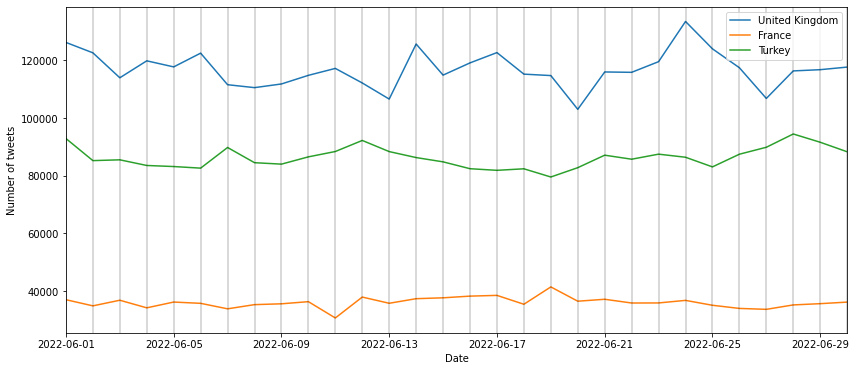

In [31]:
plt.figure(figsize = (14,6))
plt.plot(tweets_GB_sorted['date'], tweets_GB_sorted['tweet_count'], label = 'United Kingdom')
plt.plot(tweets_FR_sorted['date'], tweets_FR_sorted['tweet_count'], label = 'France')
plt.plot(tweets_TR_sorted['date'], tweets_TR_sorted['tweet_count'], label = 'Turkey')
format = '%b %d %Y'
plt.xlim(datetime.strptime('Jun 1 2022', format), datetime.strptime('Jun 30 2022', format))
for x in list(tweets_GB_sorted['date']):
    plt.axvline(x=x, color='black', alpha = 0.2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of tweets')
plt.show()

In [32]:
print('UK tweets mean: ', round(np.mean(tweets_GB['tweet_count']), 2))
print('France tweets mean: ', round(np.mean(tweets_FR['tweet_count']), 2))
print('Turkey tweets mean: ', round(np.mean(tweets_TR['tweet_count']), 2))

UK tweets mean:  116913.6
France tweets mean:  35991.47
Turkey tweets mean:  86282.83


### 4.2. Characterise each of these three days by 
#### a. Making a word cloud from the tweet text. [5 marks]
#### b. Any other method. [5 marks]

In [ ]:
#UK WORD CLOUD
tweets_GB = tweets_df4[(tweets_df4['country_code'] == 'GB')]
tweets_FR = tweets_df4[(tweets_df4['country_code'] == 'FR')]
tweets_TR = tweets_df4[(tweets_df4['country_code'] == 'TR')]

words_GB = tweets_GB[(tweets_GB['tweet_created_at'].dt.date == 
                      datetime.strptime('Jun 24 2022', '%b %d %Y').date())]['text'].to_list()

words_FR = tweets_FR[(tweets_FR['tweet_created_at'].dt.date == 
                      datetime.strptime('Jun 19 2022', '%b %d %Y').date())]['text'].to_list()

words_TR = tweets_TR[(tweets_TR['tweet_created_at'].dt.date == 
                      datetime.strptime('Jun 28 2022', '%b %d %Y').date())]['text'].to_list()

# 1
words_list = ' '.join(word for word in words_GB)
Stopwords = set(STOPWORDS)
c = wordcloud.WordCloud(background_color='black',
                        colormap='Set3',
                        stopwords=Stopwords,
                        max_words=200,
                        max_font_size=50,
                        random_state=42)
c.generate(words_list)
plt.figure(figsize=(8,6),dpi=100)
plt.title("United Kingdom Tweets Wordcloud")
plt.imshow(c,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 2
words_list = ' '.join(word for word in words_FR)
Stopwords = set(STOPWORDS)
c = wordcloud.WordCloud(background_color='#00acee',
                        colormap='Set3',
                        stopwords=Stopwords,
                        max_words=200,
                        max_font_size=50,
                        random_state=42)
c.generate(words_list)
plt.figure(figsize=(8,6),dpi=100)
plt.title("France Tweets Wordcloud")
plt.imshow(c,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 3
words_list = ' '.join(word for word in words_TR)
Stopwords = set(STOPWORDS)
c = wordcloud.WordCloud(background_color='black',
                        colormap='Set3',
                        stopwords=Stopwords,
                        max_words=200,
                        max_font_size=50,
                        random_state=42)
c.generate(words_list)
plt.figure(figsize=(8,6),dpi=100)
plt.title("Turkey Tweets Wordcloud")
plt.imshow(c,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
words_GB_dict = {}
Stopwords = set(STOPWORDS)

for text in words_GB:
    words = text.split(" ")
    for word in words:
        if word not in stopwords.words('english') and word not in Stopwords:
            if word not in words_GB_dict:
                words_GB_dict[ word ] = 1
            else:
                words_GB_dict[ word ] += 1

words_GB_dict = dict(sorted(words_GB_dict.items(), key=lambda item: item[1], reverse=True))
words_GB_dict = dict(itertools.islice(words_GB_dict.items(), 100))
words_GB_df = pd.DataFrame(words_GB_dict.items(), columns=['words', 'count'])

In [ ]:
print(Stopwords)

In [ ]:
words_GB_dict

In [ ]:
fig = px.treemap(words_GB_df[0:100], path=['words'],
                 values='count',
                 color='count',
                 color_continuous_scale='viridis',
                 color_continuous_midpoint=np.average(words_GB_df['count'])
                )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### 4.3. Summarise the events you have detected and validate your discussion with some other source of data e.g. news articles. [5 marks]

In [ ]:
g_map = gpd.read_file('./content/Data/world-administrative-boundaries.shp')
geometry = [Point(xy) for xy in zip(tweets_df3_1['longitude'], tweets_df3_1['latitude']) ]
geo_df = gpd.GeoDataFrame(tweets_df3_1,
                          crs = {'init': 'epsg:4326'},
                          geometry = geometry)

countries = set(list(tweets_df3_1['country_code'].values))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
custom_xlim = (-24.5, 69.1)
custom_ylim = (34.8, 81.9)
# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
g_map.plot(ax = ax, alpha = 0.3)

for c in countries:
    geo_df[ geo_df['country_code'] == c ].plot(ax = ax, markersize = 0.5, label = c)
plt.legend(bbox_to_anchor = (1.72, 0.5), loc='center right', ncol=5, markerscale=10)

In [14]:
pip install fastkml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygeoif: filename=pygeoif-0.7-py3-none-any.whl size=19018 sha256=c69ddc25a71d408ccc8ccd093a3b8a76a85759b75847f7a8a87e270bc3431712
  Stored in directory: /Users/garimendra/Library/Caches/pip/wheels/1f/03/f4/8041459258b17a1bc9c057a947cc1841a21084b8c8f06877c3
Successfully built pygeoif
Note: you may need to restart the kernel to use updated packages.


In [15]:
from fastkml import kml
import csv

In [16]:
place = {'code':[],'name':[],'density':[]}
with open('Coursework/Dataset/KS101EW_LA.csv','r') as csvfile:
    reader = csv.reader(csvfile,delimiter=',',quotechar='"')
    next(reader)
    for row in reader:
        place['code'].append(row[2])
        place['name'].append(row[1])
        place['density'].append(float(row[-1]))
pdf = pd.DataFrame(place)

In [23]:
with open("Coursework/Dataset/Local_Authority_Districts_December_2015_Boundaries.kml.xml",'r',encoding='utf-8') as myfile:
    doc = myfile.read()

k = kml.KML()
k.from_string(doc)
document = list(k.features())
folder = list(document[0].features())
places = list(folder[0].features())
code_to_polygon = {}
for p in places:
    poly = p.geometry
    for d in p.extended_data.elements[0].data:
        if d['name'] == 'lad15cd':
            id_code = d['value']
        if d['name'] == 'lad15nm':
            name = d['value']
    code_to_polygon[id_code] = poly

FileNotFoundError: [Errno 2] No such file or directory: 'Coursework/Dataset/Local_Authority_Districts_December_2015_Boundaries.kml.xml'

In [ ]:
geometry = [code_to_polygon[c] for c in pdf['code']]
gdf = geopandas.GeoDataFrame(pdf,crs='EPSG:4326',geometry=geometry)
gdf.plot('density',legend=True,cmap='jet',edgecolor='k',linewidth=0.4,
         norm=LogNorm(vmin=gdf['density'].min(),vmax=gdf['density'].max()),figsize=(8,4))
plt.title('Population density of England')
plt.show()

In [ ]:
place = {'code':[],'name':[],'density':[]}
with open('/content/KS101EW_LA.csv','r') as csvfile:
    reader = csv.reader(csvfile,delimiter=',',quotechar='"')
    next(reader)
    for row in reader:
        place['code'].append(row[2])
        place['name'].append(row[1])
        place['density'].append(float(row[-1]))
pdf = pd.DataFrame(place)

In [ ]:
with open("/content/Local_Authority_Districts__December_2015__Boundaries.kml.xml",'r',encoding='utf-8') as myfile:
    doc = myfile.read().encode('utf-8')

k = kml.KML()
k.from_string(doc)
document = list(k.features())
folder = list(document[0].features())
places = list(folder[0].features())
code_to_polygon = {}
for p in places:
    poly = p.geometry
    for d in p.extended_data.elements[0].data:
        if d['name'] == 'lad15cd':
            id_code = d['value']
        if d['name'] == 'lad15nm':
            name = d['value']
    code_to_polygon[id_code] = poly


geometry = [code_to_polygon[c] for c in pdf['code']]
gdf = gpd.GeoDataFrame(pdf,crs='EPSG:4326',geometry=geometry)
gdf.plot('density',legend=True,cmap='jet',edgecolor='k',linewidth=0.4,
         norm=LogNorm(vmin=gdf['density'].min(),vmax=gdf['density'].max()),figsize=(8,4))
plt.title('Population density of England')
plt.show()